In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# **<h2 style="color: red;">Importing</h2>**

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)  # Set the display width to avoid line breaks

import warnings
warnings.filterwarnings('ignore')

# **<h2 style="color: red;">Defining the dataset</h2>**

### Titanic Dataset

I used the Titanic dataset to implement supervised learning algorithms. My main goal is to predict whether a passenger will survive or not using the characteristics of the passengers.

#### Target Variable
- The target variable of the dataset is **Survived**, where:
  - `0` means **not survived**
  - `1` means **survived**

#### Features
I tried to predict the survival outcome using the following variables:
- **Gender** (sex)
- **Age** (age in years)
- **Class** (ticket class: 1st, 2nd, or 3rd)
- **Number of siblings/spouses aboard** (sibsp)
- **Number of parents/children aboard** (parch)


In [3]:
trainDf = pd.read_csv("/kaggle/input/titanic/train.csv")
testDf = pd.read_csv("/kaggle/input/titanic/test.csv")

In [4]:
df = pd.concat([trainDf,testDf] , ignore_index =True)

# **<h4 style="color: red;">EDA - Exploratory Data Analysis</h4>**

In [5]:
def check_df(data, head=5):
    print(f'Dimensions of this dataset : {data.shape}')
    print("**********************************************************")
    
    # Display first few rows
    print(f"First {head} row of the dataset:\n")
    print(data.head(head).to_string(index=False))  # Display the data rows formatted
    print("\n**********************************************************")
    
    print(f"Numerical information about this dataset:\n{data.describe()}")
    print("\n**********************************************************")
    
    print(f"General information about the dataset : {data.info()}")
    print("\n**********************************************************")
    
    print(f"How many total null values ​​are there in this data set?\n{data.isnull().sum()}")
    print("\n**********************************************************")
    
    print(f"Are there any repeated observations in this data set?\n{data.duplicated().sum()}")

check_df(df)


Dimensions of this dataset : (1309, 12)
**********************************************************
First 5 row of the dataset:

 PassengerId  Survived  Pclass                                                Name    Sex  Age  SibSp  Parch           Ticket    Fare Cabin Embarked
           1       0.0       3                             Braund, Mr. Owen Harris   male 22.0      1      0        A/5 21171  7.2500   NaN        S
           2       1.0       1 Cumings, Mrs. John Bradley (Florence Briggs Thayer) female 38.0      1      0         PC 17599 71.2833   C85        C
           3       1.0       3                              Heikkinen, Miss. Laina female 26.0      0      0 STON/O2. 3101282  7.9250   NaN        S
           4       1.0       1        Futrelle, Mrs. Jacques Heath (Lily May Peel) female 35.0      1      0           113803 53.1000  C123        S
           5       0.0       3                            Allen, Mr. William Henry   male 35.0      0      0           373450  

In [6]:
# Calculating average ages by gender
mean_age_by_sex = df.groupby('Sex')['Age'].mean()

# Filling in missing age values by gender
df['Age'] = df.apply(lambda row: mean_age_by_sex[row['Sex']] if pd.isnull(row['Age']) else row['Age'], axis=1)

# Filling missing values with average for Fare
df['Fare'].fillna(df['Fare'].mean(), inplace=True)
# Filling missing values for Embarked with mod
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

In [7]:
# Dropping columns and assigning them to a new data frame
df = df.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], axis=1)

# Checking the final state of the data frame
print(df.head())


   Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       0.0       3    male  22.0      1      0   7.2500        S
1       1.0       1  female  38.0      1      0  71.2833        C
2       1.0       3  female  26.0      0      0   7.9250        S
3       1.0       1  female  35.0      1      0  53.1000        S
4       0.0       3    male  35.0      0      0   8.0500        S


**I removed the unnecessary features that I will not use in the dataset and that are not required for my model.**

In [8]:
# Display all duplicated rows
duplicated_rows = df[df.duplicated()]
print(duplicated_rows)

      Survived  Pclass     Sex        Age  SibSp  Parch    Fare Embarked
47         1.0       3  female  28.687088      0      0  7.7500        Q
76         0.0       3    male  30.585228      0      0  7.8958        S
77         0.0       3    male  30.585228      0      0  8.0500        S
87         0.0       3    male  30.585228      0      0  8.0500        S
95         0.0       3    male  30.585228      0      0  8.0500        S
...        ...     ...     ...        ...    ...    ...     ...      ...
1254       NaN       3    male  27.000000      0      0  8.6625        S
1271       NaN       3    male  30.585228      0      0  7.7500        Q
1301       NaN       3  female  28.687088      0      0  7.7500        Q
1304       NaN       3    male  30.585228      0      0  8.0500        S
1307       NaN       3    male  30.585228      0      0  8.0500        S

[149 rows x 8 columns]


In [9]:
# Drop duplicates, keeping only the first occurrence
df = df.drop_duplicates()

# Display the cleaned DataFrame
df.duplicated().sum()

0

In [10]:
df.isnull().sum()

Survived    380
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
dtype: int64

In [11]:
# Remove rows with missing 'Survived' values
df = df.dropna(subset=['Survived'])


# **<h2 style="color: red;">Data Visualization</h2>**

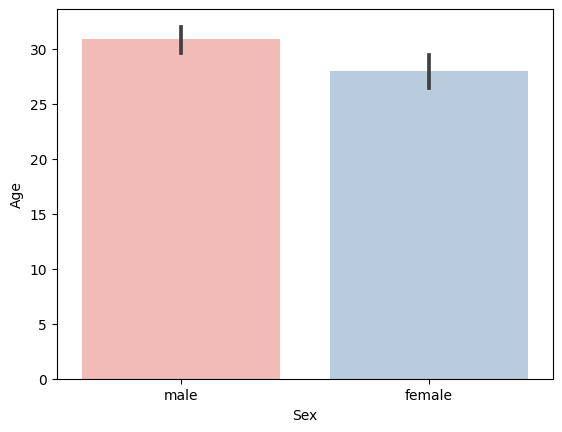

In [12]:
sns.barplot(x=df["Sex"], y=df["Age"], data=df , palette="Pastel1");

- **This graph visualizes the average ages for both genders as bars.**
- **The graph compares the average ages by gender.**
- **According to the data, the average age of male passengers is over 30.**
- **The average age of female passengers is over 25.**
- **This shows that males are generally older than females.**


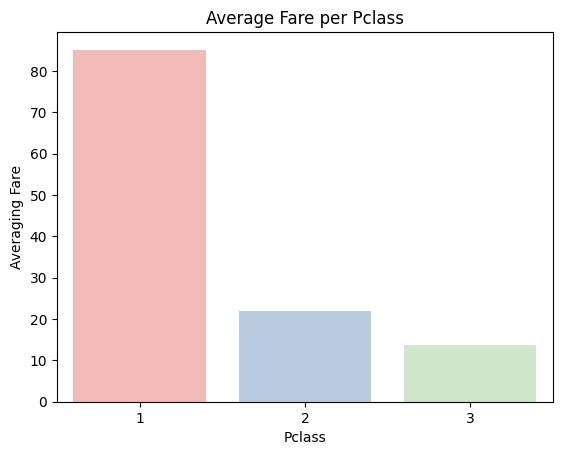

In [13]:
average_fare_per_class = df.groupby('Pclass')['Fare'].mean().reset_index()

sns.barplot(data=average_fare_per_class, x='Pclass', y='Fare',palette="Pastel1")
plt.title('Average Fare per Pclass')
plt.xlabel('Pclass')
plt.ylabel('Averaging Fare')
plt.show()

- **The graph clearly shows the relationship between ticket class and fare, and clearly shows that higher classes have higher fares.**
- **The average fare for first class (Pclass 1) is higher than the other two classes, indicating that 1st class tickets are generally more expensive. This suggests that 1st class tickets, which generally offer higher standards of comfort and service, are more costly.**

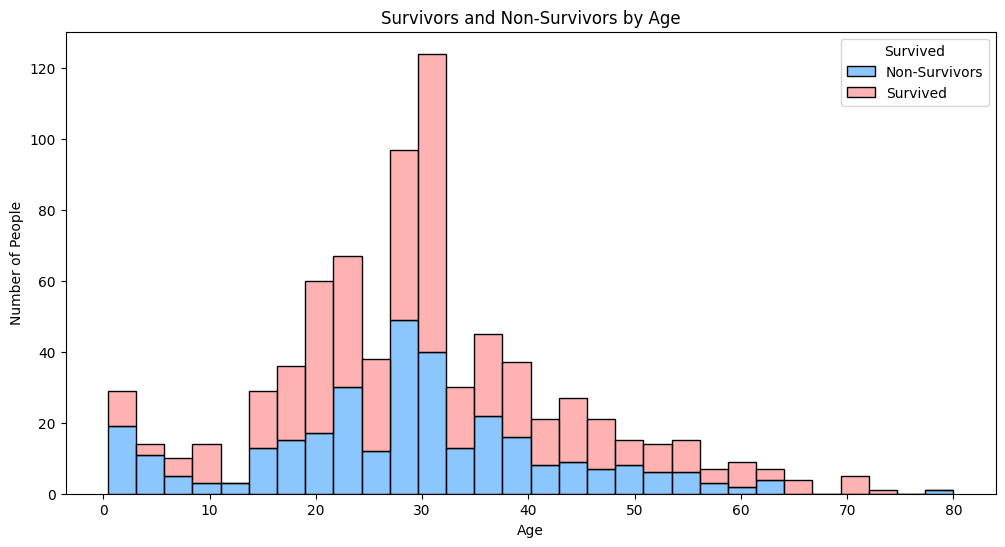

In [14]:
# Pastel renk paleti tanımlama
pastel_palette = {0: '#ff9999', 1: '#66b3ff'}

# Hayatta kalan ve kalmayanları yaşa göre görselleştirme
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Age', hue='Survived', multiple='stack', palette=pastel_palette, bins=30)
plt.title('Survivors and Non-Survivors by Age')
plt.xlabel('Age')
plt.ylabel('Number of People')
plt.legend(title='Survived', labels=['Non-Survivors', 'Survived'])
plt.show()

- **The graph compares the numerical distribution of surviving and non-surviving passengers by age.**
- **The survival rate is higher at younger ages (especially between 20-30 years old), and the survival rate decreases as age increases.** 
- **Especially in the childhood age group (0-10 years old), the survival rate is quite high.**

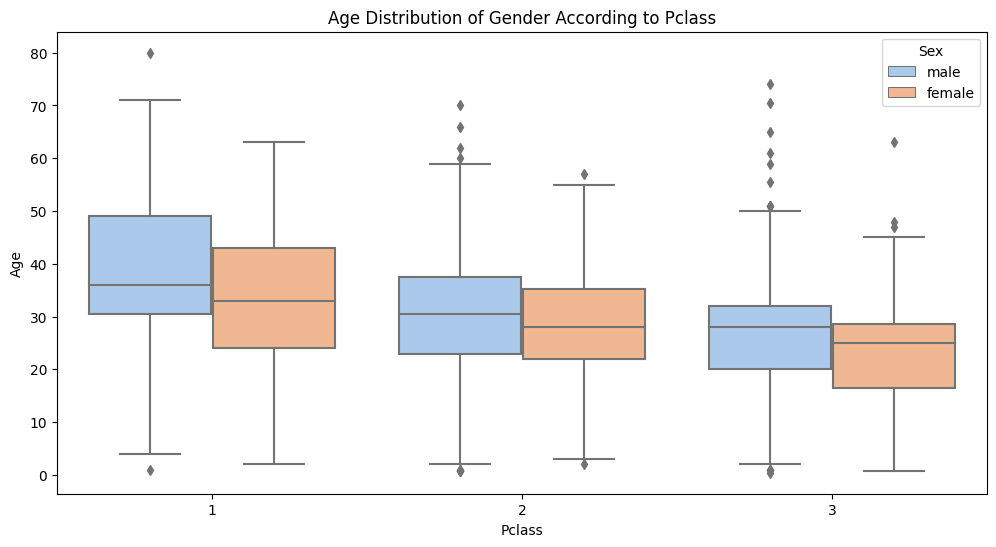

In [15]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Pclass', y='Age', hue='Sex', palette='pastel')
plt.title('Age Distribution of Gender According to Pclass')
plt.xlabel('Pclass')
plt.ylabel('Age')
plt.legend(title='Sex')
plt.show()


- **1st class (Pclass 1):** The average age is higher for both males and females. The age distribution of male passengers is concentrated between 20 and 50 years old, while the age distribution for female passengers is wider (between 20 and 60 years old).
- **2nd class (Pclass 2):** The age range is wider, but the median age is lower than in Class 1. The age distribution for men is wider and contains extreme values, while the ages for women are more tightly distributed.
- **3rd class (Pclass 3):** The average age of passengers in 3rd class is the lowest. The median age of female passengers is lower than that of male passengers. There are also more extreme values in this class, meaning there is more difference between ages.
- As the class decreases (from 1 to 3), it can be observed that the average age of both male and female passengers decreases. While there are older passengers in the 1st class, young passengers predominate in the 3rd class.


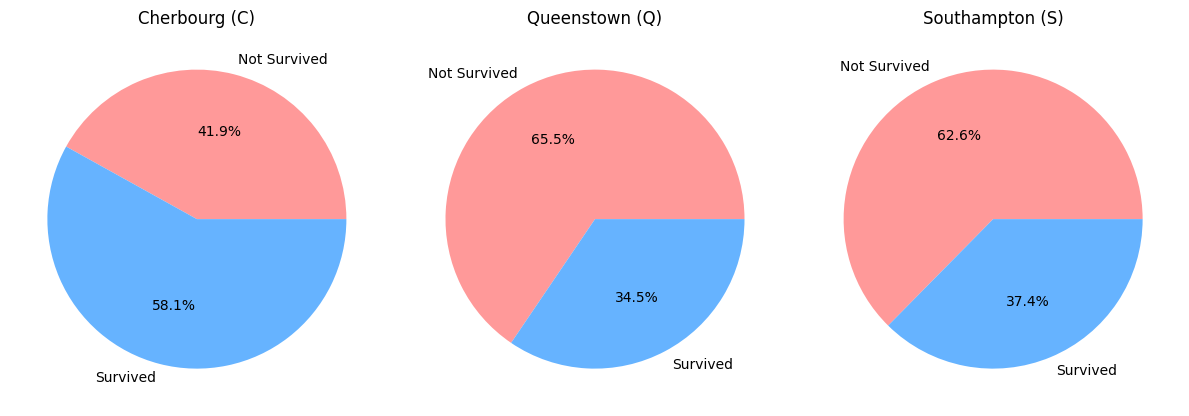

In [16]:
# Her limandan hayatta kalan ve kalmayanların sayısını hesaplama
embarked_survival = df.groupby(['Embarked', 'Survived']).size().unstack().fillna(0)

# Her limanda hayatta kalanların oranını hesaplama
embarked_survival_ratio = embarked_survival.div(embarked_survival.sum(axis=1), axis=0)

# Pasta grafiği oluşturma
plt.figure(figsize=(12, 6))

# C limanı için pasta grafiği
plt.subplot(1, 3, 1)
plt.pie(embarked_survival.loc['C'], labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Cherbourg (C)')

# Q limanı için pasta grafiği
plt.subplot(1, 3, 2)
plt.pie(embarked_survival.loc['Q'], labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Queenstown (Q)')

# S limanı için pasta grafiği
plt.subplot(1, 3, 3)
plt.pie(embarked_survival.loc['S'], labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Southampton (S)')

plt.tight_layout()
plt.show()


- **Passengers embarking from Cherbourg have a higher survival rate compared to the other two ports. This may mean that passengers embarking from Cherbourg may be in a better socio-economic situation or have a better position during the rescue process.**
- **Survival rates for Queenstown and Southampton passengers are quite similar and low, suggesting that many of the passengers boarding the ship from these ports may have been 3rd class passengers.**

In [17]:
# Convert categorical variables to numerical values
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
df['Embarked'] = df['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df["Age"] = df["Age"].astype(int)

In [18]:
# Corelation matrix
correlation_matrix = df.corr()
print(correlation_matrix["Survived"].sort_values())

Pclass     -0.336244
Embarked   -0.155701
Age        -0.082916
SibSp      -0.037597
Parch       0.069669
Fare        0.246669
Sex         0.513615
Survived    1.000000
Name: Survived, dtype: float64


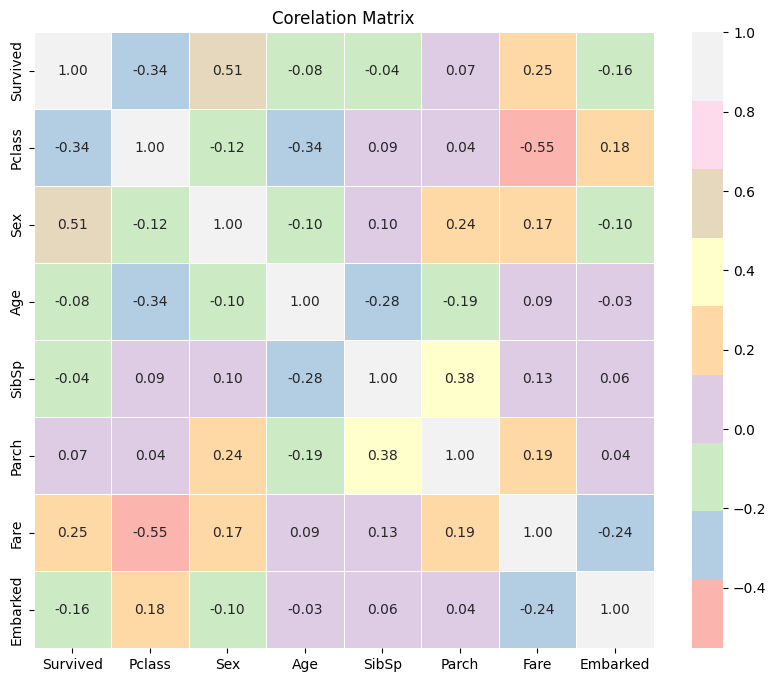

In [19]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Pastel1', fmt='.2f', linewidths=0.5)
plt.title('Corelation Matrix')
plt.show()

- **There is a strong correlation between gender and survival. It is 0.51. Similarly, there is a strong negative correlation between Pclass variable and survival compared to others. It is -0.33.**
- **Again, when we examine the table, we see that there is a positive moderate relationship between the amount the passenger pays for the ticket (Fare) and survival.**


# **<h2 style="color: red;">Data Preprocessing</h2>**

In [20]:
# Label Encoder 
le = LabelEncoder()
df['Pclass_Label'] = le.fit_transform(df['Pclass'].astype(str))

# Survived sütununu integer'a dönüştür
df['Survived'] = df['Survived'].astype(int)

# Sonuçları yazdır
print(df.head())

   Survived  Pclass  Sex  Age  SibSp  Parch     Fare  Embarked  Pclass_Label
0         0       3    0   22      1      0   7.2500         2             2
1         1       1    1   38      1      0  71.2833         0             0
2         1       3    1   26      0      0   7.9250         2             2
3         1       1    1   35      1      0  53.1000         2             0
4         0       3    0   35      0      0   8.0500         2             2


In [21]:
# split features and target
X = df.drop('Survived', axis=1)
y = df['Survived']

# splitting train and test set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [22]:
# standartizing the features.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

- **All categorical variables were converted to numerical values, which enabled the algorithms to work with this data.**
- **Standardization allowed the data to be rescaled so that the mean was 0 and the standard deviation was 1.**
- **The target variable was separated and the features and target variable were split into training and test sets.**

# **<h2 style="color: red;">Models of Machine Learning</h2>**

- **The models used include techniques such as Logistic Regression, K-Nearest Neighbor (KNN), Support Vector Machines (SVM), Decision Trees and Random Forest. The aim is to select the most appropriate model by examining the strengths and weaknesses of each model.**

In [23]:
#Defining the models
models = {
    "Logistic Regression" : LogisticRegression(),
    "KNN" : KNeighborsClassifier(n_neighbors=10),
    "SVM" : SVC(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(n_estimators=100, random_state=42)
}


results = {}
# Models training and evaulation.
for name, model in models.items():
    #print(f"Model Name: {name}")
    #print(f"Model Object: {model}")
    
    #model training with training datas.
    model.fit(X_train_scaled , y_train)
    
    #predict on the test dataset.
    y_pred = model.predict(X_test_scaled)
    
    #evaulate preformance
    accuracy = accuracy_score(y_test , y_pred)
    conf_matrix = confusion_matrix(y_test , y_pred)
    class_report = classification_report(y_test,y_pred)
    
    #keep results
    results[name] = {
        "Accuracy" : accuracy,
        "Confusion Matrix" : conf_matrix,
        "Classification Report" : class_report
    }
    
    
    #print the results
    print(f"Model : {name}")
    print(f"Accuracy : {accuracy}")
    print(f"Confusion Matrix :\n {conf_matrix}")
    print(f"Classification Report:\n {class_report}")
    print("-"*50)

Model : Logistic Regression
Accuracy : 0.782051282051282
Confusion Matrix :
 [[76 15]
 [19 46]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82        91
           1       0.75      0.71      0.73        65

    accuracy                           0.78       156
   macro avg       0.78      0.77      0.77       156
weighted avg       0.78      0.78      0.78       156

--------------------------------------------------
Model : KNN
Accuracy : 0.8076923076923077
Confusion Matrix :
 [[82  9]
 [21 44]]
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.85        91
           1       0.83      0.68      0.75        65

    accuracy                           0.81       156
   macro avg       0.81      0.79      0.80       156
weighted avg       0.81      0.81      0.80       156

--------------------------------------------------
Model : SVM
Accurac

### Model Performance Analysis
1. **Logistic Regression**
   - **Accuracy**: %78.21
   -  Logistic regression shows good performance in general, especially on survivors with a slightly lower recall value.
2. **K-Nearest Neighbor (KNN)**
   - **Accuracy**: %80.77
   - KNN provides a good balance for both classes, especially on survivors with a higher precision.
3. **Support Vector Machines (SVM)**
   - **Accuracy**: %81.41
   - SVM has a high recall value, especially for class 0, and its overall accuracy is quite satisfactory.
4. **Decision Trees**
   - **Accuracy**: %73
   - Decision trees show lower accuracy than other models. Especially on survivors, more incorrect predictions were made.
5. **Random Forest**
   - **Accuracy**: %82.05
   - Random Forest is the model with the highest accuracy. It provides a good balance for both classes and the false prediction rate is lower than other models.

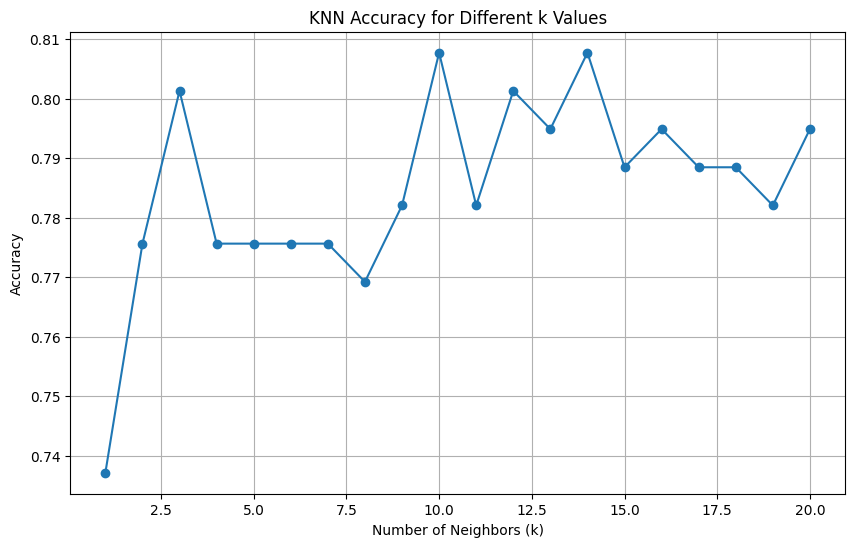

In [24]:
# Evaluating the accuracy rates to find the best k
k_range = range(1, 21)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    scores.append(accuracy_score(y_test, y_pred))

# Visualizing the best k value and accuracy rate
plt.figure(figsize=(10, 6))
plt.plot(k_range, scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k Values')
plt.grid(True)
plt.show()


-  **The 10th k value seems to give the best results. In the KNN algorithm, too small or too large k can damage the model. A small k can cause the model to be too sensitive and affected by noise. A very large k can reduce the generalization ability of the model.**
- **Overall, the model's accuracy ranges between 74% and 81%, indicating that the model performs quite well on the dataset.However, further fine-tuning is possible.**

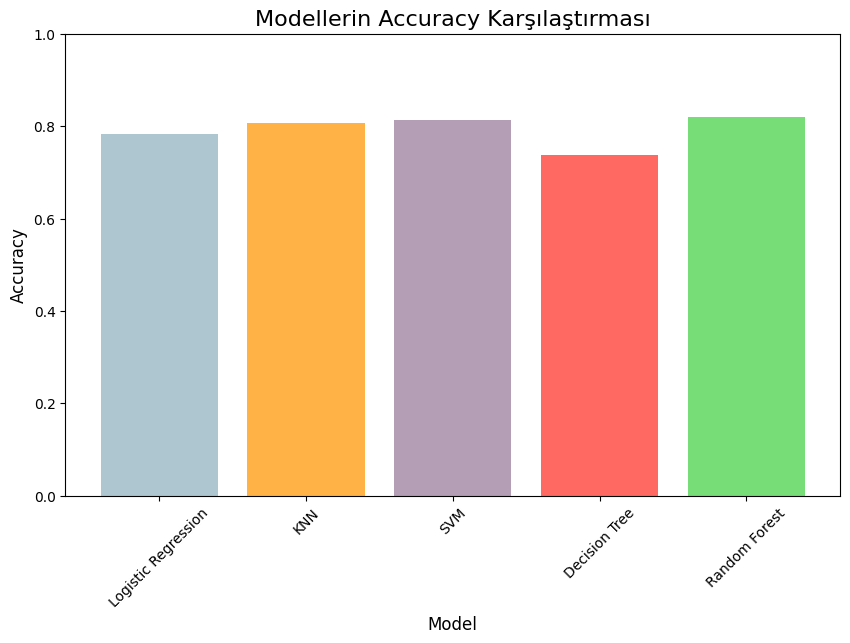

In [25]:
# Getting Accuracy scores
accuracy_scores = {name: result["Accuracy"] for name, result in results.items()}

# Pastel color palette
colors = ['#AEC6CF', '#FFB347', '#B39EB5', '#FF6961', '#77DD77'] 

# Visualizing Accuracy scores
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values(), color=colors)
plt.title('Modellerin Accuracy Karşılaştırması', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1) 
plt.xticks(rotation=45, fontsize=10)  # angled display
plt.show()


### General Evaluation
- **Best Performance**: Random Forest shows the best performance with the highest accuracy and balanced precision-recall values.This model is better able to distinguish subtle differences between surviving and non-surviving individuals, demonstrating how effective the model is in predicting survival. 

- **SVM ve KNN**: These models are also quite successful, but they are not as powerful as Random Forest.

- **Logistic Regression**: It performs well, but has lower accuracy than other models.

- **Decision Trees**: It has the lowest accuracy rate, which may indicate that the model is overfitting or not adequately capturing the complexity in the data.